<a href="https://colab.research.google.com/github/Gurpreet654/Traffic-Flow-Analysis-and-Prediction-Using-Bicycle-Data-from-Strava-App-Enhanced-by-Machine-Learning/blob/main/Speed_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium
import numpy as np

In [2]:
a=pd.read_csv('cf2.csv')

In [3]:
a.head()

,latitude,longitude,elevation,time,index,unique_id
0,52.337590,9.716907,58.6,2024-09-09 10:38:20+00:00,1,Afternoon_Ride (1)
1,52.337590,9.716907,58.6,2024-09-09 10:38:21+00:00,2,Afternoon_Ride (1)
2,52.337339,9.717196,58.7,2024-09-09 10:38:23+00:00,3,Afternoon_Ride (1)
3,52.337375,9.717230,58.7,2024-09-09 10:38:24+00:00,4,Afternoon_Ride (1)
4,52.337360,9.717307,58.8,2024-09-09 10:38:25+00:00,5,Afternoon_Ride (1)


In [26]:
a1=a[a['unique_id']=='Afternoon_Ride (1)']

In [7]:
center_lat, center_lon = a1['latitude'].mean(), a1['longitude'].mean()
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)
path_coordinates = list(zip(a1['latitude'], a1['longitude']))

folium.PolyLine(
    path_coordinates,
    color="blue",
    weight=5,
    opacity=0.7
).add_to(my_map)


In [33]:
import pandas as pd
from geopy.distance import geodesic
import datetime

df = pd.DataFrame(a1)
df['time'] = pd.to_datetime(df['time'])

# Initialize a list to store speeds
speeds = [0]  # Speed for the first row is undefined, so we start with 0

# Calculate speed between consecutive points
for i in range(1, len(df)):
    # Get the previous and current points
    coord_prev = (df.loc[i - 1, 'latitude'], df.loc[i - 1, 'longitude'])
    coord_curr = (df.loc[i, 'latitude'], df.loc[i, 'longitude'])

    # Calculate distance in meters
    distance_meters = geodesic(coord_prev, coord_curr).km


    # Calculate time difference in seconds
    time_diff_seconds = (df.loc[i, 'time'] - df.loc[i - 1, 'time']).total_seconds()
    time_diff_seconds=time_diff_seconds/3600
    # Calculate speed in m/s (distance / time)
    speed_m_s = distance_meters / time_diff_seconds if time_diff_seconds > 0 else 0
    speeds.append(speed_m_s)

# Add speed to DataFrame
df['speed_m_s'] = speeds

# Display the DataFrame with calculated speeds
df.head()


,latitude,longitude,elevation,time,index,unique_id,speed_m_s
0,52.337590,9.716907,58.6,2024-09-09 10:38:20+00:00,1,Afternoon_Ride (1),0.000000
1,52.337590,9.716907,58.6,2024-09-09 10:38:21+00:00,2,Afternoon_Ride (1),0.000000
2,52.337339,9.717196,58.7,2024-09-09 10:38:23+00:00,3,Afternoon_Ride (1),61.519302
3,52.337375,9.717230,58.7,2024-09-09 10:38:24+00:00,4,Afternoon_Ride (1),16.660453
4,52.337360,9.717307,58.8,2024-09-09 10:38:25+00:00,5,Afternoon_Ride (1),19.826562


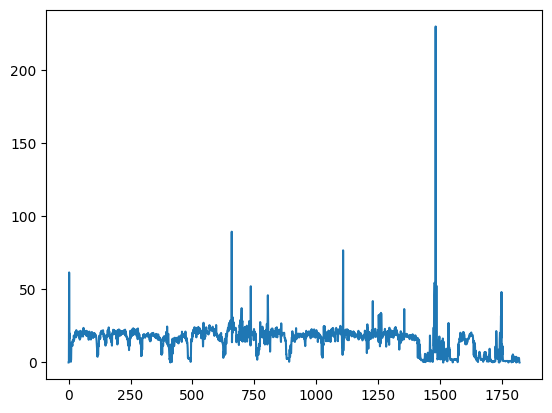

In [34]:
plt.plot(df['speed_m_s'])

check the value in the 'speed_m_s' column. If the speed is greater than 30, it replaces this value with the average of the **last 10** (or fewer if near the start) preceding values in the same column. This approach helps smooth out high-speed values by using recent historical data.

In [35]:
for i in range(len(df)):
    if df.loc[i, 'speed_m_s'] > 30:
        df.loc[i, 'speed_m_s'] = df['speed_m_s'].iloc[max(0, i-10):i].mean()

# Display the DataFrame with calculated speeds and replacements
df.head()

,latitude,longitude,elevation,time,index,unique_id,speed_m_s
0,52.337590,9.716907,58.6,2024-09-09 10:38:20+00:00,1,Afternoon_Ride (1),0.000000
1,52.337590,9.716907,58.6,2024-09-09 10:38:21+00:00,2,Afternoon_Ride (1),0.000000
2,52.337339,9.717196,58.7,2024-09-09 10:38:23+00:00,3,Afternoon_Ride (1),0.000000
3,52.337375,9.717230,58.7,2024-09-09 10:38:24+00:00,4,Afternoon_Ride (1),16.660453
4,52.337360,9.717307,58.8,2024-09-09 10:38:25+00:00,5,Afternoon_Ride (1),19.826562


Made bins data for 10-second intervals and calculates the average values for each bin:

Create 10-Second Time Bins: The column time_bin is created by rounding down each timestamp in df['time'] to the nearest 10-second interval.

Aggregate Data by Bin: The groupby function groups the data by these 10-second bins (time_bin), and for each bin, it calculates the mean of:

latitude
longitude
elevation
speed_m_s
Resulting DataFrame: The result, binned_df, contains one row per 10-second interval with the averaged values for each column.

In [74]:
df['time_bin'] = df['time'].dt.floor('10S')

# Aggregate by each 10-second bin
binned_df = df.groupby('time_bin').agg({
    'latitude': 'mean',             # Average latitude for each bin
    'longitude': 'mean',            # Average longitude for each bin
    'elevation': 'mean',            # Average elevation for each bin
    'speed_m_s': 'mean'             # Average speed for each bin
}).reset_index()

# Display the binned DataFrame
binned_df.head()

<ipython-input-74-768dc5f64854>:1: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df['time_bin'] = df['time'].dt.floor('10S')


,time_bin,latitude,longitude,elevation,speed_m_s
0,2024-09-09 10:38:20+00:00,52.337414,9.717201,58.733333,4.802613
1,2024-09-09 10:38:30+00:00,52.337370,9.717318,58.800000,0.469765
2,2024-09-09 10:38:40+00:00,52.337401,9.717037,58.887500,11.738244
3,2024-09-09 10:38:50+00:00,52.337307,9.716600,59.000000,16.958818
4,2024-09-09 10:39:00+00:00,52.337188,9.715900,59.060000,19.415385


In [75]:
len(binned_df)

197

In [76]:
binned_df['mean']=binned_df['speed_m_s'].mean()

In [77]:
binned_df['sb']=binned_df['speed_m_s']

In [78]:
binned_df['mean']=binned_df['speed_m_s'].mean()

<Axes: >

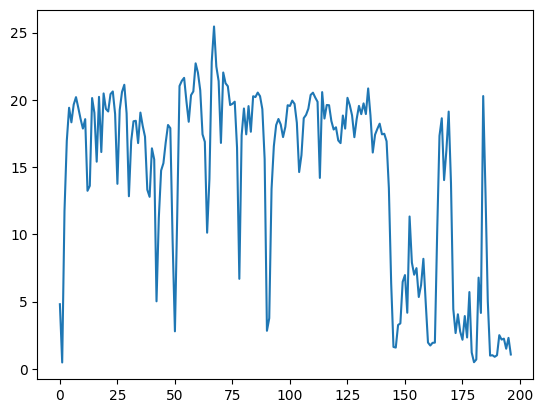

In [79]:
binned_df['speed_m_s'].plot()

In [80]:
for i in range(len(binned_df)):
    if binned_df.loc[i, 'sb'] < binned_df.loc[i,'mean']:
        binned_df.loc[i, 'sb'] = binned_df.loc[i, 'speed_m_s']
    else:
        binned_df.loc[i, 'sb'] = np.nan

# Display the DataFrame with calculated speeds and replacements
binned_df.head()

,time_bin,latitude,longitude,elevation,speed_m_s,mean,sb
0,2024-09-09 10:38:20+00:00,52.337414,9.717201,58.733333,4.802613,14.344371,4.802613
1,2024-09-09 10:38:30+00:00,52.337370,9.717318,58.800000,0.469765,14.344371,0.469765
2,2024-09-09 10:38:40+00:00,52.337401,9.717037,58.887500,11.738244,14.344371,11.738244
3,2024-09-09 10:38:50+00:00,52.337307,9.716600,59.000000,16.958818,14.344371,NaN
4,2024-09-09 10:39:00+00:00,52.337188,9.715900,59.060000,19.415385,14.344371,NaN


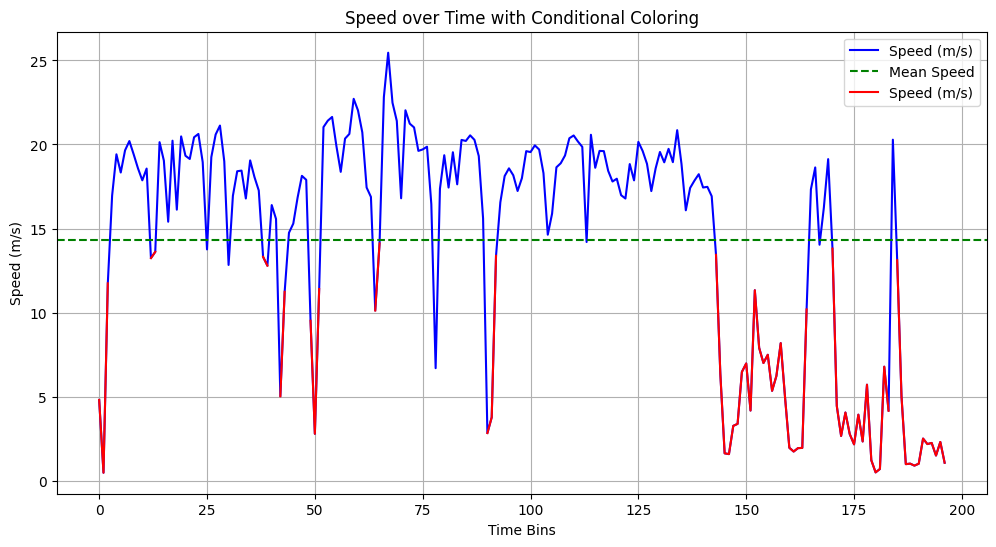

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming binned_df is already defined and contains 'speed_m_s' and 'mean' columns

# Plotting speed
plt.figure(figsize=(12, 6))
binned_df['speed_m_s'].plot(label='Speed (m/s)', color='blue')

# Plotting mean speed
binned_df['mean'] = binned_df['speed_m_s'].mean()  # Assuming 'mean' is a column to be defined
plt.axhline(binned_df['mean'][0], color='green', linestyle='--', label='Mean Speed')
binned_df['sb'].plot(label='Speed (m/s)', color='red')
# Adding labels and legend
plt.title('Speed over Time with Conditional Coloring')
plt.xlabel('Time Bins')
plt.ylabel('Speed (m/s)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
center_lat, center_lon = a1['latitude'].mean(), a1['longitude'].mean()
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)
path_coordinates = list(zip(a1['latitude'], a1['longitude']))

folium.PolyLine(
    path_coordinates,
    color="blue",
    weight=5,
    opacity=0.7
).add_to(my_map)


In [88]:
for i in range(len(binned_df)):
    if pd.isna(binned_df.loc[i, 'sb']):  # Correct way to check for NaN
        binned_df.loc[i, 'latitude'] = np.nan
        binned_df.loc[i, 'longitude'] = np.nan

# Display the DataFrame with calculated speeds and replacements
binned_df.head()

,time_bin,latitude,longitude,elevation,speed_m_s,mean,sb
0,2024-09-09 10:38:20+00:00,52.337414,9.717201,58.733333,4.802613,14.344371,4.802613
1,2024-09-09 10:38:30+00:00,52.337370,9.717318,58.800000,0.469765,14.344371,0.469765
2,2024-09-09 10:38:40+00:00,52.337401,9.717037,58.887500,11.738244,14.344371,11.738244
3,2024-09-09 10:38:50+00:00,NaN,NaN,59.000000,16.958818,14.344371,NaN
4,2024-09-09 10:39:00+00:00,NaN,NaN,59.060000,19.415385,14.344371,NaN


In [87]:
import folium
import pandas as pd
import numpy as np

a1=binned_df
# Center the map around the average location
center_lat, center_lon = a1['latitude'].mean(), a1['longitude'].mean()
my_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Loop through each point, color segments based on speed
for i in range(len(a1) - 1):
    # Get coordinates for the current and next point
    start_coords = (a1['latitude'].iloc[i], a1['longitude'].iloc[i])
    end_coords = (a1['latitude'].iloc[i + 1], a1['longitude'].iloc[i + 1])

    # Define color based on whether speed is NaN
    color = "red" if pd.isna(a1['sb'].iloc[i]) else "green"

    # Create a line segment between points with the specified color
    folium.PolyLine(
        [start_coords, end_coords],
        color=color,
        weight=5,
        opacity=0.7
    ).add_to(my_map)

# Display the map
my_map


In [86]:
binned_df

,time_bin,latitude,longitude,elevation,speed_m_s,mean,sb
0,2024-09-09 10:38:20+00:00,52.337414,9.717201,58.733333,4.802613,14.344371,4.802613
1,2024-09-09 10:38:30+00:00,52.337370,9.717318,58.800000,0.469765,14.344371,0.469765
2,2024-09-09 10:38:40+00:00,52.337401,9.717037,58.887500,11.738244,14.344371,11.738244
3,2024-09-09 10:38:50+00:00,52.337307,9.716600,59.000000,16.958818,14.344371,NaN
4,2024-09-09 10:39:00+00:00,52.337188,9.715900,59.060000,19.415385,14.344371,NaN
...,...,...,...,...,...,...,...
192,2024-09-09 11:14:10+00:00,52.371487,9.666701,71.800000,2.175397,14.344371,2.175397
193,2024-09-09 11:14:30+00:00,52.371523,9.666544,71.716667,2.241671,14.344371,2.241671
194,2024-09-09 11:14:40+00:00,52.371507,9.666535,71.700000,1.492394,14.344371,1.492394
195,2024-09-09 11:14:50+00:00,52.371507,9.666647,71.657143,2.301302,14.344371,2.301302


In [89]:
a1

,time_bin,latitude,longitude,elevation,speed_m_s,mean,sb
0,2024-09-09 10:38:20+00:00,52.337414,9.717201,58.733333,4.802613,14.344371,4.802613
1,2024-09-09 10:38:30+00:00,52.337370,9.717318,58.800000,0.469765,14.344371,0.469765
2,2024-09-09 10:38:40+00:00,52.337401,9.717037,58.887500,11.738244,14.344371,11.738244
3,2024-09-09 10:38:50+00:00,NaN,NaN,59.000000,16.958818,14.344371,NaN
4,2024-09-09 10:39:00+00:00,NaN,NaN,59.060000,19.415385,14.344371,NaN
...,...,...,...,...,...,...,...
192,2024-09-09 11:14:10+00:00,52.371487,9.666701,71.800000,2.175397,14.344371,2.175397
193,2024-09-09 11:14:30+00:00,52.371523,9.666544,71.716667,2.241671,14.344371,2.241671
194,2024-09-09 11:14:40+00:00,52.371507,9.666535,71.700000,1.492394,14.344371,1.492394
195,2024-09-09 11:14:50+00:00,52.371507,9.666647,71.657143,2.301302,14.344371,2.301302
